# Analysis of Monthly Retail Trade Survey (MRTS) Data as of February 2021

**Stephen Re**

# Index

- [Abstract](#Abstract)
- [1. Introduction](#1.-Introduction)
- [2. Extract-Transform-Load](#2.-Extract-Transform-Load)
    - [2.1 The ETL Process](#2.1-The-ETL-Process)
    - [2.2 Data Exploration](#2.2-Data-Exploration)
    - [2.3 Data Preparation](#2.3-Data-Preparation)
    - [2.4 Read the Data Using Python](#2.4-Reading-the-Data-Using-Python)
         - [2.4.1 Reading Sample Data](#2.4.1-Reading-Sample-Data)
         - [2.4.2 Reading the MRST Data](#2.4.2-Reading-the-MRST-Data)
    - [2.5 Writing an Installation Script](#2.5-Writing-an-Installation-Script)
- [3. Analysis and Visualization](#3.-Project-Description)
    - [3.1 Running Queries in MySQL Workbech](#3.1-Running-Queries-in-MySQL-Workbech)
    - [3.2 Running Queries From Python](#3.2-Running-Queries-From-Python)
    - [3.3 Explore Trends](#3.3-Explore-Trends)
    - [3.4 Explore Percentage Change](#3.4-Explore-Percentage-Change)
    - [3.5 Explore Rolling Time Windows](#3.5-Explore-Rolling-Time-Windows)
- [Conclusion](#Conclusion)
- [References](#References)

fdg[Back to top](#Index)


##  Abstract

The Monthly Retail Trade Survey data is a great source of longitudinal economic activity data going back to 1992.  The data has its flaws and isn’t perfectly formatted, but it is consistent which makes analysis of long term trends easier.

Digging into the data with a few example industries showed an overall steady upward trend to economic activity in the retail trade, with the exception of the years of the great recession.  There was one notable exception to this overall strong growth, however.  As one might expect, bookstores have been in steady decline for two decades now.  The only bright spot for the industry on a yearly basis is the back-to-school rush which roughly matches its holiday season sales.  When analyzing the data using inflation adjusted dollars, the picture is even worse.

[Back to top](#Index)


## 1. Introduction

There are several steps to completing this project which has been laid out in the headers below.
First, the longest and most difficult part of the process was the ETL.  I was able to write a script that:
- pulled out the individual excel sheets into separate csv files
- cleaned and organized them into a standardized format
- enriched the data with monthly CPI index data from the St Louis Fed website to help with inflation adjustment analysis.
- created an installation script in SQL
- installed the data into MySQL

Once that was done and tested, I was able to start my exploration and analysis.  I started exploring the data in depth using the suggested topics as a guide in order to find patterns that I could use to tell a story.  Once I had a general story in mind, I decided on what visualizations I wanted to use and set about building the queries in SQL and the visualizations using seaborn. 

Below you will find more information and narrative in the headers regarding the individual steps and findings, as well as commented code so you can follow along with my process.


[Back to top](#Index)

## 2. Extract-Transform-Load


[Back to top](#Index)

### 2.1 The ETL Process

Key Steps for processing MRTS dataset:
- read each tab in the .xls file into individual csv files.
- clean data.  See section "2.3 Data Preparation" for details.
- create installation script for MySQL
- connect to MySQL
- run installation script

Please see the commented code below for step by step explanations.

In [3]:
# import libraries
import pandas as pd
import numpy as np
import os
import mysql.connector as mc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

In [4]:
# creating MySQL connection config using yaml config file.  I am doing this at the top of the notebook because it will be a shared resource throughout.
cnx_config_load = yaml.safe_load(open('mod_8_config.yaml'))

config = {
    'host': cnx_config_load['mod_8_config']['host'],
    'user': cnx_config_load['mod_8_config']['user'],
    'password': cnx_config_load['mod_8_config']['password'],
    'database': cnx_config_load['mod_8_config']['db'],
    'auth_plugin': 'mysql_native_password'
}


[Back to top](#Index)

### 2.2 Data Exploration

I am just like my dachshunds: built and bred to find and go down as many rabbit holes as I run across.  That is why my projects take so long.  I cant help but find new and interesting ways to work with and explore data.  Honestly, I need to learn to just stick to the basics.

I did a lot of exploration of the NAICS dataset and found the NAICS and MRTS manuals on the census bureau website.  That helped me understand what the codes really meant and how the MRTS reports are built and interpreted.  The NAICS dataset for MRTS is only concerned with NAICS sectors 44 and 45 (Retail Trade), and subsector 722 (Food Services and Drinking Places).

Because i am an economics nerd, I couldn’t leave well enough alone, so I went to the St Louis Fed website to get the seasonally adjusted monthly Consumer Price Index figures.  That way i could adjust the sales amounts into Feb 2021 dollars to show nominal vs inflation adjusted trends.

I then used the charting tools on the St. Louis Fed and the Bureau of Labor Statistics websites to check that my CPI data was correct.  

Regarding the data itself, I found it interesting, but not surprising, that there were choices made in 1992 with the first publication that have followed through to today.  For instance, including 4411 and 4412 on the same line, but not breaking them out on subsequent lines.  I assume they continued those choices all the way to today for consistency, but I would be curious to know why those decisions were made.


[Back to top](#Index)

### 2.3 Data Preparation

My goal was to put all of the csv files into one table with the grain of month_year and NAICS code. The point being that it will be easier to use for visualizations and run aggregations if the data is unpivoted to have one  column for every month and the corresponding columns of numbers instead of trying to aggregate across multiple columns of data.  The SQL queries will be much easier if it is in this form.
I created some new columns to also help with aggregations:
- splitting month_year:
    - month
    - year
- datetime column for the first day of each month.  This way I could have a datetime column to use for time series analysis.

I decided not to use the adjusted data from the MRTS files, but opted to use the CPI indexing instead because that includes inflation adjustments.


[Back to top](#Index)

### 2.4 Read the Data Using Python

The Pandas library is great for exactly this sort of thing. Once your data is read into a dataframe, pandas can be used to do a lot, if not all of your data cleaning tasks.  I am not normally used to data cleaning with anything but SQL, so i have been impressed with the Pandas' versatility.  Below you will see the code i used to clean each of the individual yearly csv files.

[Back to top](#Index)

### 2.4.1 Reading Sample Data

I have used the 2018 data in csv form.  No particular reason.  It was the first complete year that I started working with and just continued with it because it seemed like a good testbed.

I also used the CPI data described below to enhance the data.  I downloaded it from the site and created the monthly ratios using the formula:  
##### (feb 2021 index / each monthly index) *  amount.  
The first term gets us the ratio of month to Feb 2021.  Then multiplying the amounts of each category in the MRTS sheets gets us the adjusted amounts.

I then used the code for the 2018 cleaning research to create the overall cleaning script in 2.4.2 below.  I have fully commented the code so you can follow along.


[Back to top](#Index)

### 2.4.2 Reading the MRTS Data

Step by Step description of the cleaning script below.  The code is fully commented also.
- break up xls file into individual yearly csv files
- for each yearly csv file:
    - load file
    - update column names
    - add surrogate keys for first 7 lines
    - keep rows of unadjusted data and drop the rest
    - cast columns as numeric
    - disaggregate '4411,4412' row and add new 4412 row
    - drop rows '4411,4412' and '442,443' as they are unneeded
    - adjusted NAICS code for row '722513, 722514, 722515'
    - fix '(NA)' and '(S)' cells as NaN
    - reset index
    - add df to dict
    - use pd.melt() to unpivot the data into the grain:
        - NAICS_code
        - month_year
- concat the year dfs into one full_df
- add columns:
    - year
    - month
    - month_start (used this one to merge with inflation adjustment df)
- load inflation adjustment csv into df
- merge inflation adjustment df into full_df
- add inflation adjusted dollar amount column
- create final_df by selecting only needed columns from merged df
- write final_df to csv file



In [372]:
# First, we need to loop through the tabs in the .xls sheet and save them as seperate csv files.
xls_file = 'MRTS/mrtssales92-present.xls'

xls = pd.ExcelFile(xls_file, engine='xlrd')

for sheet_name in xls.sheet_names:
    df = xls.parse(sheet_name)
    csv_file = f"MRTS/MRTS_year_files/MRTS_{sheet_name}.csv"
    df.to_csv(csv_file, index=False)

    print(f"Saved {sheet_name} to {csv_file}")

Saved 2021 to MRTS/MRTS_year_files/MRTS_2021.csv
Saved 2020 to MRTS/MRTS_year_files/MRTS_2020.csv
Saved 2019 to MRTS/MRTS_year_files/MRTS_2019.csv
Saved 2018 to MRTS/MRTS_year_files/MRTS_2018.csv
Saved 2017 to MRTS/MRTS_year_files/MRTS_2017.csv
Saved 2016 to MRTS/MRTS_year_files/MRTS_2016.csv
Saved 2015 to MRTS/MRTS_year_files/MRTS_2015.csv
Saved 2014 to MRTS/MRTS_year_files/MRTS_2014.csv
Saved 2013 to MRTS/MRTS_year_files/MRTS_2013.csv
Saved 2012 to MRTS/MRTS_year_files/MRTS_2012.csv
Saved 2011 to MRTS/MRTS_year_files/MRTS_2011.csv
Saved 2010 to MRTS/MRTS_year_files/MRTS_2010.csv
Saved 2009 to MRTS/MRTS_year_files/MRTS_2009.csv
Saved 2008 to MRTS/MRTS_year_files/MRTS_2008.csv
Saved 2007 to MRTS/MRTS_year_files/MRTS_2007.csv
Saved 2006 to MRTS/MRTS_year_files/MRTS_2006.csv
Saved 2005 to MRTS/MRTS_year_files/MRTS_2005.csv
Saved 2004 to MRTS/MRTS_year_files/MRTS_2004.csv
Saved 2003 to MRTS/MRTS_year_files/MRTS_2003.csv
Saved 2002 to MRTS/MRTS_year_files/MRTS_2002.csv
Saved 2001 to MRTS/M

In [5]:
# Full cleaning script

# create dict to hold all dataframes
df_dict = {}

# list of basic column names to be customized later
col_names=['NAICS_code', 'Business_type', 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December', 'TOTAL', 'Feb. 2021(p)']

# list of column names that are edge cases that need to be removed
removed_col_names = ['CY CUM', 'PY CUM', 'Feb. 2021(p)_2016', 'Unnamed: 15']

'''
main cleaning script:
for each yearly csv file:
    load file
    update column names
    add surogate keys for first 7 lines
    keep rows of unadjusted data and drop the rest
    cast columns as numeric
    disaggregate 4411,4412 row and add new 4412 row
    drop unneeded rows
    fix '(NA)' and '(S)' cells as NaN
    reset index
    add df to dict
'''
for file in os.listdir('MRTS/MRTS_year_files'):
    year = file[5:9]
    df_col_names = []

    # pulling each csv into a dataframe to clean and organize it.
    new_df = pd.read_csv(f'MRTS/MRTS_year_files/{file}', skiprows=[0,1,2,3,5] ,header=0)#, names=['NAICS_code', 'Business_type'] + df_col_names)
    n_col = 0
    for n in new_df.columns:
        if n not in removed_col_names:
            n_col+=1
    for n in col_names[2:n_col]:
         df_col_names.append(f'{n} {year}')
    new_df = new_df.iloc[:,:n_col]

    # renaming columns     
    new_col_names = ['NAICS_code', 'Business_type'] + df_col_names
    new_df.columns = new_col_names

    # add "sector" keys to the 7 aggregate values at the top of the sheet.
    # I am keeping them because it might be easier to do time series analysis using preaggregated than building the aggregations myself.
    new_df.iloc[0:7,0] = range(1,8)

    #removing the bottom adjusted data and all of the rest of the unneccesary rows.
    new_df = new_df[:65]

    # I need to reduce the last code in the series to only one NAICS code.
    # There is no way to break out or determine which code to use.
    # After doing some research, it makes sense to use 722513 as the stand-in for these codes.
    new_df.iloc[-1,0] = 722513

    # replacing '(S)' values with 0 for now so i can convert all of the columns to int data type.
    # I will get rid of those cells when i put everything together.
    new_df[new_df.iloc[:,2:] == '(S)'] = np.nan
    new_df[new_df.iloc[:,2:] == '(NA)'] = np.nan

    # converting columns to numeric
    for col in new_df.columns[2:]:
        new_df[col] = pd.to_numeric(new_df[col])
        
    # codes 4411 and 4412 share a line.  4411 is browken out individually, but not 4412.
    # I decided to create a row that subtracts 4411 from the total to get 4412 by itself.
    new_row = {}
    new_row['NAICS_code']=4412
    new_row['Business_type']='Other Motor Vehicle Dealers'
    for col in new_df.columns[2:]:
        new_row[col] = new_df.iloc[8][col]-new_df.iloc[9][col]
    new_df.loc[len(new_df)] = new_row

    # now that i have the disggregated row for 4412, i can get rid of the preaggregated row.
    # dropping NAICS_code=='4411,4412' because, now that we have split it out, we dont need this line.
    new_df.drop(new_df[new_df.NAICS_code=='4411,4412'].index, inplace=True)
    new_df.drop(new_df[new_df.NAICS_code=='44,114,412'].index, inplace=True)

    # dropping NAICS_code=='442,443' because both subcatagories have already been broken out below, so this line isnt needed.
    new_df.drop(new_df[new_df.NAICS_code=='442,443'].index, inplace=True)

    # reset index
    new_df.reset_index(inplace=True)
    new_df.head(15)

    df_dict[f'df_{year}'] = new_df
    # print(df_dict[f'df_{year}'].columns)

# unpivoting eaech file into NAICS_code, month_year grain
# list for conating dfs
melted_list = []

for file in os.listdir('MRTS/MRTS_year_files'):
    # create list of value columns to unpivot
    year = file[5:9]
    a = df_dict[f'df_{year}'].columns[3:]

    # melt (unpivot) each file
    df_dict[f'df_{year}_melted'] = pd.melt(df_dict[f'df_{year}'],
                                          id_vars=['NAICS_code', 'Business_type'], 
                                          value_vars=a,
                                          var_name='month_year', 
                                          value_name='sales')
    # building final df
    melted_list.append(df_dict[f'df_{year}_melted'])
    mrts_df = pd.concat(melted_list, ignore_index=True)
# adding month and year columns for easier analysis
mrts_df['year'] = mrts_df['month_year'].str[-4:]
mrts_df['month'] = mrts_df['month_year'].str[:-5]

# add month_start date column to join on cpi_df
month_dict = dict(zip(pd.date_range('1992-01-01', freq='ME', periods=12).strftime('%B'),
             pd.date_range('1992-01-01', freq='ME', periods=12).strftime('%m') + '-01'))
mrts_df['month_start'] = mrts_df['year'] + '-' + mrts_df['month'].map(month_dict)

mrts_df['year'] = pd.to_numeric(mrts_df['year'])
mrts_df['NAICS_code'] = pd.to_numeric(mrts_df['NAICS_code'])

In [6]:
# read in CPI adjustment data csv
cpi_df = pd.read_csv('MRTS/CPI_Index_calc.csv')

In [7]:
# merge inflation adjustment data and mrts data
full_df = pd.merge(mrts_df, cpi_df[['DATE', 'feb2021_multiple']], left_on='month_start', right_on='DATE')

# add inflation adjustment column.
full_df['cpi_adjd'] = round(full_df['sales'] * full_df['feb2021_multiple'])

# creating table in its final form
final_df = full_df[['NAICS_code', 'Business_type', 'month_year', 'year', 'month', 'month_start', 'sales', 'cpi_adjd']].copy()

#casting month_start as datetime for easier use in queries
final_df['month_start'] = pd.to_datetime(final_df['month_start'])

# dropping any rows that have a NaN introduced during the etl script.  these would be the rows originally having 'S' or 'NA'.
final_df.drop(final_df[final_df['sales'].isna()].index, inplace=True)

In [610]:
# writing new csv file for import to MySQL
csv_file = f"MRTS/MRTS_Data.csv"
final_df.to_csv(csv_file, index=False)

[Back to top](#Index)

### 2.5 Writing an Installation Script

I created the installation script to be able to run the entire creation of the database and table in one script.  See the commented code below for details.

In [269]:
# creating sql file for install script.  saves to sql file.

# path to output sql file
output_file = 'mrts_data.sql'

# prep statements
create_statement = '''DROP DATABASE IF EXISTS module_8_project;
CREATE DATABASE IF NOT EXISTS module_8_project;
USE module_8_project;
DROP TABLE IF EXISTS mrts_data;
CREATE TABLE IF NOT EXISTS mrts_data (NAICS_code int, Business_type varchar(200), month_year varchar(50), year int, month varchar(20), month_start datetime, sales float, cpi_adjd float);\n'''

# list to hold values of each row
value_list = []

# populate value_list
for i, row in final_df.iterrows():
    values = ','.join([f"'{str(val).replace("'", "''")}'" for val in row.tolist()])
    sql = f'({values})'
    value_list.append(sql)

# turn value_list into string
value_str = ',\n'.join(value_list)

# create full sql insert statement
insert_statement = f'INSERT INTO mrts_data(NAICS_code, Business_type, month_year, year, month, month_start, sales, cpi_adjd)\nVALUES\n{value_str};'

# write to sql file
with open(output_file, 'w') as file:
    file.write(create_statement)
    file.write(insert_statement)

In [26]:
# install database and mrts table using sql script

cnx = mc.connect(**config)

with open('mrts_data.sql', 'r') as install_file:
    sql_script = install_file.read()

# split script into individual statements
split_statement = sql_script.split(';\n')

cursor = cnx.cursor()

# run each statement one at a time
for statement in split_statement:
    try:
        cursor.execute(statement)
        cnx.commit()
    except mc.Error as err:
        print(f"Error: {err}")
        cnx.rollback()
        break
    
cursor.close()
cnx.close()

DROP DATABASE IF EXISTS module_8_project
CREATE DATABASE IF NOT EXISTS module_8_project
USE module_8_project
DROP TABLE IF EXISTS mrts_data
CREATE TABLE IF NOT EXISTS mrts_data (NAICS_code int, Business_type varchar(200), month_year varchar(50), year int, month varchar(20), month_start datetime, sales float, cpi_adjd float)
INSERT INTO mrts_data(NAICS_code, Business_type, month_year, year, month, month_start, sales, cpi_adjd)
VALUES
('1','Retail and food services sales, total','January 1992','1992','January','1992-01-01 00:00:00','146376.0','273195.0'),
('2','Retail sales and food services excl motor vehicle and parts','January 1992','1992','January','1992-01-01 00:00:00','116565.0','217556.0'),
('3','Retail sales and food services excl gasoline stations','January 1992','1992','January','1992-01-01 00:00:00','134277.0','250613.0'),
('4','Retail sales and food services excl motor vehicle and parts and gasoline stations','January 1992','1992','January','1992-01-01 00:00:00','104466.0','1


[Back to top](#Index)

## 3. Analysis and Visualization


[Back to top](#Index)

### 3.1 Running Queries in MySQL Workbech

I used SQL scripts below to pull general data regarding the questions i was going to answer, then further refined the data using pandas dataframes to feed the visuals.  The queries i built are in the analysis code below.  

To verify the data was correct, I ran select * queries and put the results into an excel sheet for spot checks.  This is something I do often when I am validating data.

[Back to top](#Index)

### 3.2 Running Queries From Python

After building and spot checking the SQL statements I wrote, I ran them using pd.read_sql and the MySQL connection I built earlier to build dataframes.  I then filtered them further in pandas to refine the dataframes for use in the visualizations.

[Back to top](#Index)

### 3.3 Explore Trends


##### Retail and Food Service Sales Trends
In the first cell is the SQL query i used to pull data from MySQL.  I wrote and tested the query in MySQL, then brought it over here to put into a dataframe.  I then refined the data as needed using pandas in the next cells to feed the charts.

The industry grew at a steady rate from 1992 to 2020 with a 3 year slowdown and dip between 2007 and 2010 because of the Great Recession.

For the first plot (fig 1), I reduced the details down to yearly averages instead of monthly as that would have made the graph too choppy and the x axis overcrowded.  Yearly numbers show trends of long periods of time very well.

In the second plot (fig 2), I wanted to zoom in to show the panic of March 2020 as the pandemic started hitting home.  It is a little hard to see due to the choppiness of the data, so i put vertical lines on Dec 2018 and 2019 to show the seasonal highs.  It is much easier to see then that there was a large dip in March 2020 when viewed from those reference points.

In [8]:
cnx = mc.connect(**config)

query = (
    '''
    select
        m.naics_code,
        m.business_type,
        m.month_start,
        m.month_year,
        m.year,
        m.sales,
        m.cpi_adjd
    from mrts_data m
    where naics_code in (1, 5)
        ;
         ''')
rafs_df = pd.read_sql(query, cnx)

cnx.close()


C:\Users\sre\AppData\Local\Temp\ipykernel_22172\3763603352.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  rafs_df = pd.read_sql(query, cnx)


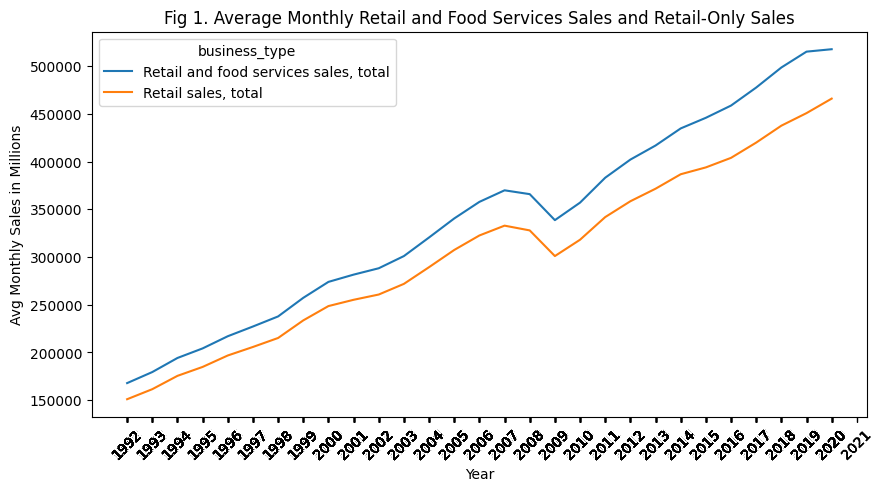

In [28]:
# creating retail and food service dataframe with 2 series: overall retail and food service sales, and retail only sales totals.
rafs = rafs_df[['business_type', 'year', 'sales', 'cpi_adjd']][rafs_df['year'] < 2021]

#setting figure size to better visualize data and spread out the x axis ticks.
fig = plt.subplots(figsize=(10, 5))

# building and refining seaborn lineplot
sns.lineplot(x='year', y='sales', data=rafs, hue='business_type', errorbar=None)
plt.title('Fig 1. Average Monthly Retail and Food Services Sales and Retail-Only Sales')
plt.xlabel('Year')
plt.ylabel('Avg Monthly Sales in Millions')
plt.xticks(rafs_df['year'], rotation=45)
plt.show()

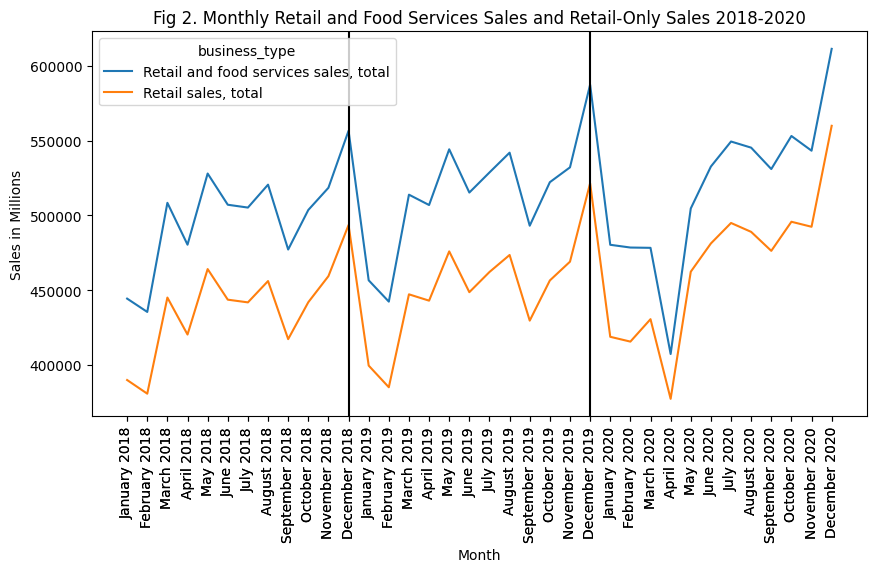

In [29]:
# creating the same dataframe as above, but restricting year to 2018-2020.
rafs = rafs_df[['business_type', 'month_year', 'sales', 'cpi_adjd']][(rafs_df['year'] >= 2018) & (rafs_df['year'] <= 2020)]

#setting figure size to better visualize data and spread out the x axis ticks.
fig = plt.subplots(figsize=(10, 5))

# building and refining seaborn lineplot
sns.lineplot(x='month_year', y='sales', data=rafs, hue='business_type', errorbar=None)
plt.title('Fig 2. Monthly Retail and Food Services Sales and Retail-Only Sales 2018-2020')
plt.xlabel('Month')
plt.ylabel('Sales in Millions')
plt.xticks(rafs_df['month_year'][(rafs_df['year'] >= 2018) & (rafs_df['year'] <= 2020)], rotation=90)

# adding vertical bars for ease of reference 
plt.axvline(x=11, ymin=0, ymax=1, color='k')
plt.axvline(x=23, ymin=0, ymax=1, color='k')

plt.show()

##### Trends for Bookstores, Hobby and Game Stores and Sporting Goods Stores

As above, I wrote and tested the SQL statement in MySQL, then used it here to pull in the data to a dataframe.  I then refined the data further using pandas to feed the charts.

Delving into the subject of trends for Hobby, Sports and Book stores was a good reason to use the CPI inflation adjusted data along side the unadjusted numbers.  The first plot below (fig 3.1) is the raw, or nominal, dollars and the second (fig 3.2) is real dollars inflation adjusted to Feb 2021.  This really helps show how the fortunes of these 3 sectors have changed over the last 32 years.  

Sporting Goods has seen a fairly consistent rise in sales both in nominal dollars and real dollars.  It had one major downturn from 2016 to 2019, but has since recovered.  

Hobby and Game, and Bookstores have not faired as well.  In raw dollars, Hobby Stores have basically held steady since 1999, and Bookstores leveled out between 2003 and 2007 before starting to decline.  In real dollars, however, we see that both sectors have been declining since the late 90s/early 2000s, with Bookstores showing an especially heavy decline starting in 2004.  I speculate that this is when Amazon really started taking over the book marketplace.

Here are the questions posed for this section:
1. Which is the highest trend of all of these options?
    - Sporting Goods stores have had the highest sales every year. 
2. Which one grew faster? 
    - Again, Sporting Goods stores have grown faster and more consistently than the other 2 sectors over the past 32 years.
3. Which one is higher?
    - Again, Sporting Goods stores seem to be the most popular of the 3 business sectors.
4. Is there a seasonal pattern? 
    - I created a line chart (fig 4) showing the average sales of all time by month.  this shows a distinct seasonality, as one would expect, with December sales exceeding all other months.  There is some interesting nuance though.  Sporting Goods stores show higher sales in the warmer months then drop off in the colder months except December.  Hobby and Game Stores are pretty dependent on the Christmas season.  Bookstores are less dependent on Christmas, but there is also a spike in August and September presumably for school books.
5. Are there any changes in 2020?  
    - (fig 5) I recreated the 2 year window chart from above to show a that there was a big dip in sales in March and April, but then sales took off after people realized the world wasn’t coming to an end, but they had nothing to do.  Having come from the games industry early in my career, i can tell you that demand for escapes like sports, books or games increase during recessions and other economic slowdowns.
6. Which is better, monthly or yearly?
    - This depends on what you are looking for.  For seasonality and closer inspection of one or two years, monthly is best as nuance is masked by courser grain of yearly numbers.  If you want to see overall trends over a long timeframe, yearly is the best.


In [11]:
cnx = mc.connect(**config)

query = (
    '''
	SELECT
		NAICS_code,
		Business_type,
		month_year,
		month_start,
        year,
		sales,
		cpi_adjd
	FROM module_8_project.mrts_data
	where NAICS_code in (45111,	45112, 451211)
        ;
         ''')
games_df = pd.read_sql(query, cnx)

cnx.close()

C:\Users\sre\AppData\Local\Temp\ipykernel_22172\194776444.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  games_df = pd.read_sql(query, cnx)


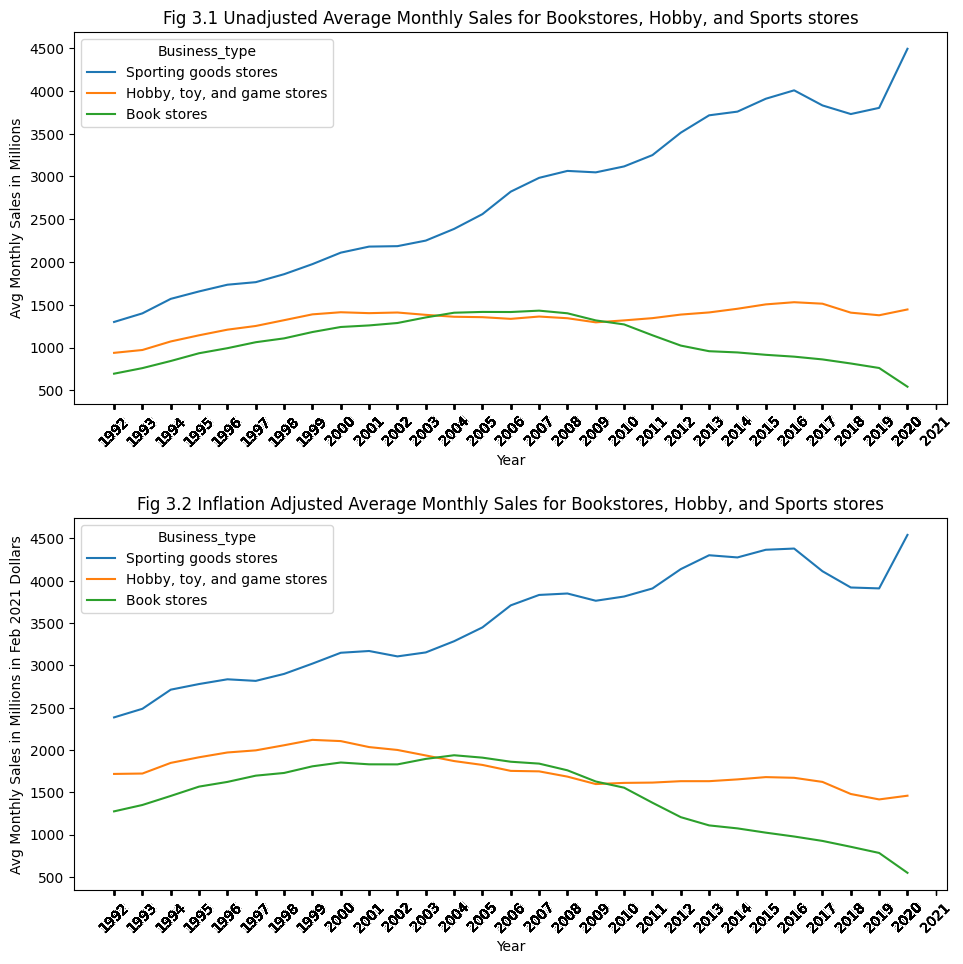

In [30]:
# creating dataframe from the games_df query.
games = games_df[['Business_type', 'year', 'sales', 'cpi_adjd']][games_df['year'] < 2021]

#setting figure size to better visualize data and spread out the x axis ticks.
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# building and refining seaborn lineplots
sns.lineplot(x='year', y='sales', data=games, hue='Business_type', errorbar=None, ax=ax1)
ax1.set_title('Fig 3.1 Unadjusted Average Monthly Sales for Bookstores, Hobby, and Sports stores')
ax1.set_xlabel('Year')
ax1.set_ylabel('Avg Monthly Sales in Millions')
ax1.set_xticks(games_df['year'])
ax1.tick_params(axis='x', rotation=45)


sns.lineplot(x='year', y='cpi_adjd', data=games, hue='Business_type', errorbar=None, ax=ax2)
ax2.set_title('Fig 3.2 Inflation Adjusted Average Monthly Sales for Bookstores, Hobby, and Sports stores')
ax2.set_xlabel('Year')
ax2.set_ylabel('Avg Monthly Sales in Millions in Feb 2021 Dollars')
ax2.set_xticks(games_df['year'])
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout(pad=2.0, w_pad=2.0, h_pad=2.0)

plt.show()

In [13]:
# creating seasonality dataset.  I go all month, but not year data for each business type, then took the average.  
# That allows us to see on average how each month performs during the year.

cnx = mc.connect(**config)

query = (
    '''
    SELECT
        NAICS_code,
        Business_type,
        month(month_start) as monthnum,
        left(month_year, length(month_year)-5) as month,
        avg(cpi_adjd) as avg_cpi_sales
    FROM module_8_project.mrts_data
    where NAICS_code in (45111,45112,451211)
    group by 
        NAICS_code,
        Business_type,
        month(month_start),
        left(month_year, length(month_year)-5)
        ;
         ''')
games_season_df = pd.read_sql(query, cnx)

cnx.close()

C:\Users\sre\AppData\Local\Temp\ipykernel_22172\3679855915.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  games_season_df = pd.read_sql(query, cnx)


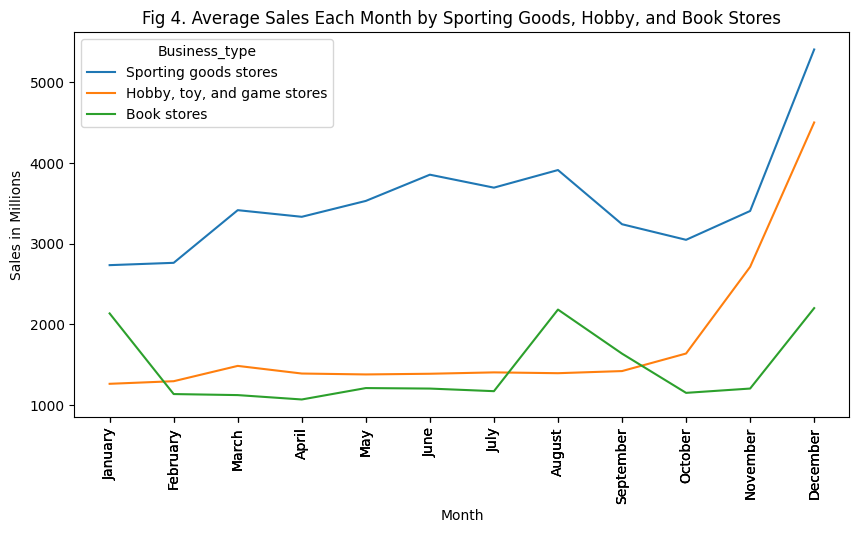

In [34]:
# building seasonality df
season = games_season_df[['Business_type', 'monthnum', 'month', 'avg_cpi_sales']]

#setting figure size to better visualize data and spread out the x axis ticks.
fig = plt.subplots(figsize=(10, 5))

# building and refining seaborn lineplot
sns.lineplot(x='month', y='avg_cpi_sales', data=season, hue='Business_type', errorbar=None)
plt.title('Fig 4. Average Sales Each Month by Sporting Goods, Hobby, and Book Stores')
plt.xlabel('Month')
plt.ylabel('Sales in Millions')
plt.xticks(season['month'], rotation=90)

plt.show()

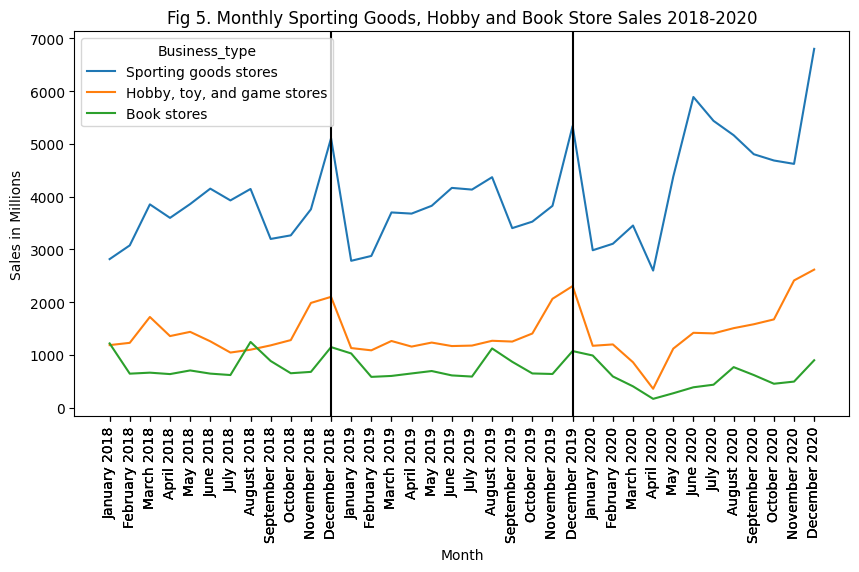

In [33]:
# creating retail and food service dataframe with 2 series: overall retail and food service sales, and retail only sales totals.
games2 = games_df[['Business_type', 'month_year', 'sales', 'cpi_adjd']][(games_df['year'] >= 2018) & (games_df['year'] <= 2020)]
games2['smoothed_sales'] = games2['sales'].rolling(window=3).mean()

#setting figure size to better visualize data and spread out the x axis ticks.
fig = plt.subplots(figsize=(10, 5))

# building and refining seaborn lineplot
sns.lineplot(x='month_year', y='sales', data=games2, hue='Business_type', errorbar=None)
plt.title('Fig 5. Monthly Sporting Goods, Hobby and Book Store Sales 2018-2020')
plt.xlabel('Month')
plt.ylabel('Sales in Millions')
plt.xticks(games_df['month_year'][(games_df['year'] >= 2018) & (games_df['year'] <= 2020)], rotation=90)

# adding vertical bars for ease of reference 
plt.axvline(x=11, ymin=0, ymax=1, color='k')
plt.axvline(x=23, ymin=0, ymax=1, color='k')

plt.show()

[Back to top](#Index)

### 3.4 Explore Percentage Change

##### Trends for Womens and Mens Clothing Retailers

*As above, I wrote and tested the SQL statement in MySQL, then used it here to pull in the data to a dataframe.  I then refined the data further using pandas to feed the charts.*

1. How are these two businesses related? 
    - Generally, women spend around 4 times more at women’s clothing retailers than men do at men’s retailers.  In 2020, at the start of the pandemic, this spiked to almost 7x. 
2. What is the percentage of contribution to the whole?
    - As of 2019, the last non-pandemic year, women’s sales made up 81% of overall sales between men’s and women’s retailers. (Fig 6)
3. how does it change over time?
    - The recent pandemic shock made the ratio between men’s and women’s retail sales shift markedly toward women.  Women’s retail sales were 87% of the whole that year.  Before the pandemic, the change was gradual over time, going from 73.5% for women’s sales in 1998 to a pre-pandemic high of 83.5% in 2011. (Fig 6)  

To further explore these trends, I made two charts to show the percent change year over year for the two sectors together and side by side.  In the first (Fig 7), you can see that sales patterns change slowly over time.  The trend has been relatively consistent growth from the late 90s to 2012 with 2 dips coinciding with the dot com bubble and the great recession.  After 2012 growth stagnated then comes the pandemic crash where sales fell 37%.

When we look at the sector broken out (Fig 8), we see a more complicated pattern.  The pct change for men’s and women’s clothing stores does not always follow each other.  It looks like men’s clothing suffers more during economic shocks than does women’s clothing.  That is most clearly seen in 2020 with men’s clothing retail sales dropping almost 60% vs women’s clothes dropping 30%.  These are interesting patterns that would be fun to dive into further.


In [ ]:
cnx = mc.connect(**config)

query = '''
select
	m.year,
    sum(sales) as sales,
	sum(case when NAICS_code = 44811 then sales end) as mens_sales,
    sum(case when NAICS_code = 44812 then sales end) as womens_sales,
    round(sum(case when NAICS_code = 44811 then sales end)/sum(sales) * 100,1) as mens_pct,
    round(sum(case when NAICS_code = 44812 then sales end)/sum(sales) * 100,1)as womens_pct,
    100.0 as total_pct
from mrts_data m
where naics_code in (44811, 44812)
group by m.year
;
''' 

clothes_df = pd.read_sql(query, cnx)

cnx.close()


C:\Users\sre\AppData\Local\Temp\ipykernel_22172\3845931590.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  clothes_df = pd.read_sql(query, cnx)


,year,sales,mens_sales,womens_sales,mens_pct,womens_pct,total_pct
0,1992,41994.0,10179.0,31815.0,24.2,75.8,100.0
1,1993,42312.0,9962.0,32350.0,23.5,76.5,100.0
2,1994,40617.0,10032.0,30585.0,24.7,75.3,100.0
3,1995,38011.0,9315.0,28696.0,24.5,75.5,100.0
4,1996,37784.0,9546.0,28238.0,25.3,74.7,100.0
5,1997,37891.0,10069.0,27822.0,26.6,73.4,100.0
6,1998,38528.0,10196.0,28332.0,26.5,73.5,100.0
7,1999,39216.0,9667.0,29549.0,24.7,75.3,100.0
8,2000,40954.0,9507.0,31447.0,23.2,76.8,100.0
9,2001,40078.0,8625.0,31453.0,21.5,78.5,100.0


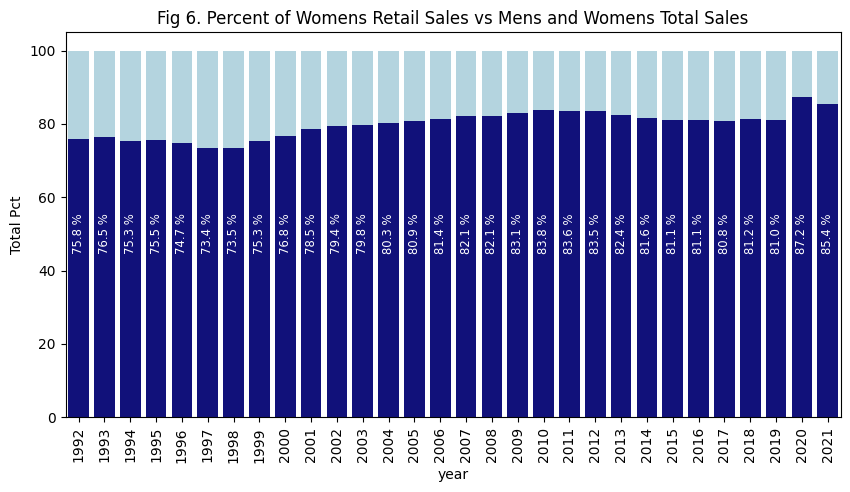

In [36]:
mens_clothes = clothes_df[['year', 'total_pct']]
womens_clothes = clothes_df[['year', 'womens_pct']]
fig, ax = plt.subplots(figsize=(10,5))

bar2 = sns.barplot(x="year", y="total_pct", data=mens_clothes, color='lightblue')
bar1 = sns.barplot(x="year",  y="womens_pct", data=womens_clothes, color='darkblue')
plt.xticks(rotation = 90)
for ix, row in womens_clothes.iterrows():
        plt.text(
            ix,
            50,
            f"{row['womens_pct']} %",
            va="center",
            ha="center",
            color='w',
            rotation=90,
            fontsize='small'
        )
plt.title('Fig 6. Percent of Womens Retail Sales vs Mens and Womens Total Sales')
plt.ylabel('Total Pct')

plt.show()

In [49]:
cnx = mc.connect(**config)

query = '''
select
	*,
    round((sales - lag(sales) over(order by year)) / lag(sales) over(order by year) * 100, 1) as pct_change
from (
	select
		m.year,
		sum(m.sales) as sales
	from mrts_data m
	where naics_code in (44811, 44812)
		and year < 2021
	group by 
		m.year
) a
;
'''

pct_clothes_df = pd.read_sql(query, cnx)

cnx.close()

C:\Users\sre\AppData\Local\Temp\ipykernel_22172\1120355179.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pct_clothes_df = pd.read_sql(query, cnx)


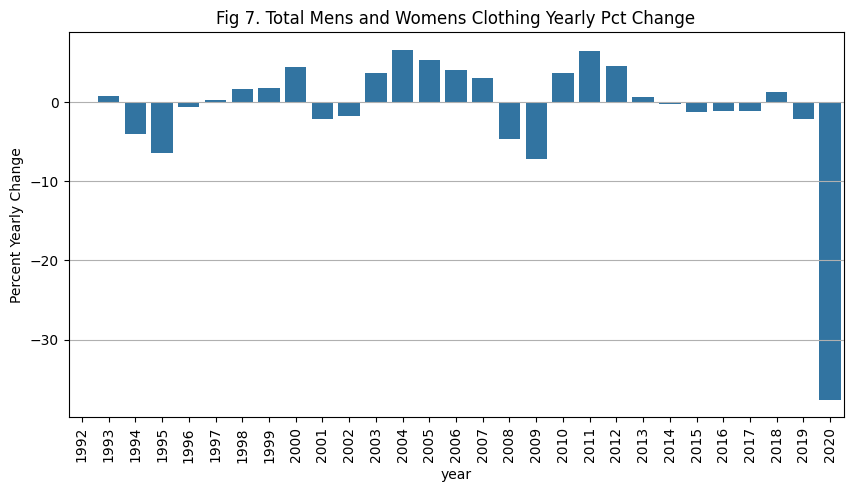

In [67]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='year', y='pct_change', data=pct_clothes_df, orient='v', errorbar=None, estimator='sum')
plt.title('Fig 7. Total Mens and Womens Clothing Yearly Pct Change')
plt.ylabel('Percent Yearly Change')
plt.xticks(rotation=90)
plt.grid(True, which='major', axis='y')

plt.show()

In [21]:
cnx = mc.connect(**config)

query='''
select
	*,
    (sales - lag(sales) over(partition by NAICS_code order by year)) / lag(sales) over(partition by NAICS_code order by year) * 100 as pct_change
from (
	select
		m.naics_code,
		m.business_type,
		m.year,
		sum(m.sales) as sales
	from mrts_data m
	where naics_code in (44811, 44812)
	group by 
		m.naics_code,
		m.business_type,
		m.year
) a
;
'''

m_w_pct_change = pd.read_sql(query, cnx)

cnx.close()

C:\Users\sre\AppData\Local\Temp\ipykernel_22172\2212211524.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  m_w_pct_change = pd.read_sql(query, cnx)


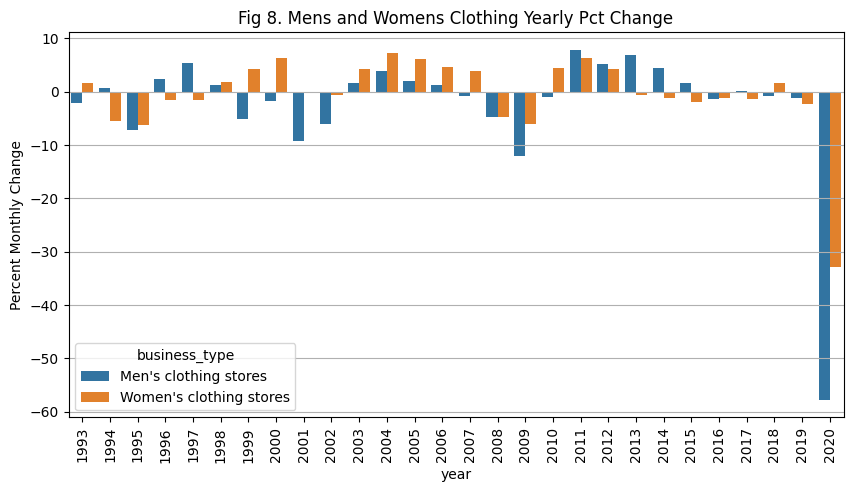

In [68]:
fig, ax = plt.subplots(figsize=(10,5))
m_w = m_w_pct_change[(m_w_pct_change['year'] >= 1993) & (m_w_pct_change['year'] <= 2020)]

sns.barplot(x='year', y='pct_change', data=m_w, hue='business_type', orient='v', errorbar=None, estimator='sum')
plt.title('Fig 8. Mens and Womens Clothing Yearly Pct Change')
plt.ylabel('Percent Monthly Change')
plt.xticks(rotation=90)
plt.grid(True, which='major', axis='y')

plt.show()

[Back to top](#Index)

### 3.5 Explore Rolling Time Windows


- In economics, what is the rolling time window and why is it considered an important measure to predict quantities like spending patterns?
    - Rolling time windows aggregate data over a specific set of time periods (eg, 3 months), then rolls the window forward to the next time (eg, 1 month) to aggregate the next set of periods. This help smooth out volatility in monthly data in order to more easily pick out trends from noisy data.
- I decided to look first into gas stations industry sales (NAICS code 447) between Jan 2017 and Feb 2021 (Fig 9).  The raw data is in grey to better see the 3 month rolling average line in blue.  While the data is a bit choppy, the 3 month rolling average smooths out the bumps to show an obvious trend: Americans like driving in the summer.
- Second, i wanted to zoom in a little more on women’s clothing sales, so i took data from Jan 2017 to Feb 2021 (Fig 10).  Again, the raw data is in grey.  The data is much more choppy than that of gas stations, but once i add the 4 month rolling average to it, we can see that sales have been pretty steady for the 3 years leading up to the pandemic, showing only seasonal changes.


In [98]:
cnx = mc.connect(**config)

query='''
select
	Business_type,
	month_year,
    month_start,
    sales,
    avg(sales) over(order by month_start rows between 2 preceding and current row) as rolling_avg_sales,
    pct_change * 100 as pct_change,
    avg(pct_change) over(order by month_start rows between 2 preceding and current row) * 100 as rolling_avg_pct
from (
    SELECT
        Business_type,
        month_year,
        month_start,
        sales,
        (sales - lag(sales) over(partition by NAICS_code order by month_start)) / lag(sales) over(partition by NAICS_code order by month_start) as pct_change
    FROM module_8_project.mrts_data
    where NAICS_code in (447)
) a
order by month_start
'''

pct_change_df = pd.read_sql(query, cnx)

cnx.close()


C:\Users\sre\AppData\Local\Temp\ipykernel_22172\1657282180.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pct_change_df = pd.read_sql(query, cnx)


C:\Users\sre\AppData\Local\Temp\ipykernel_22172\2823474697.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(pct_cng['month_year'], rotation=90)


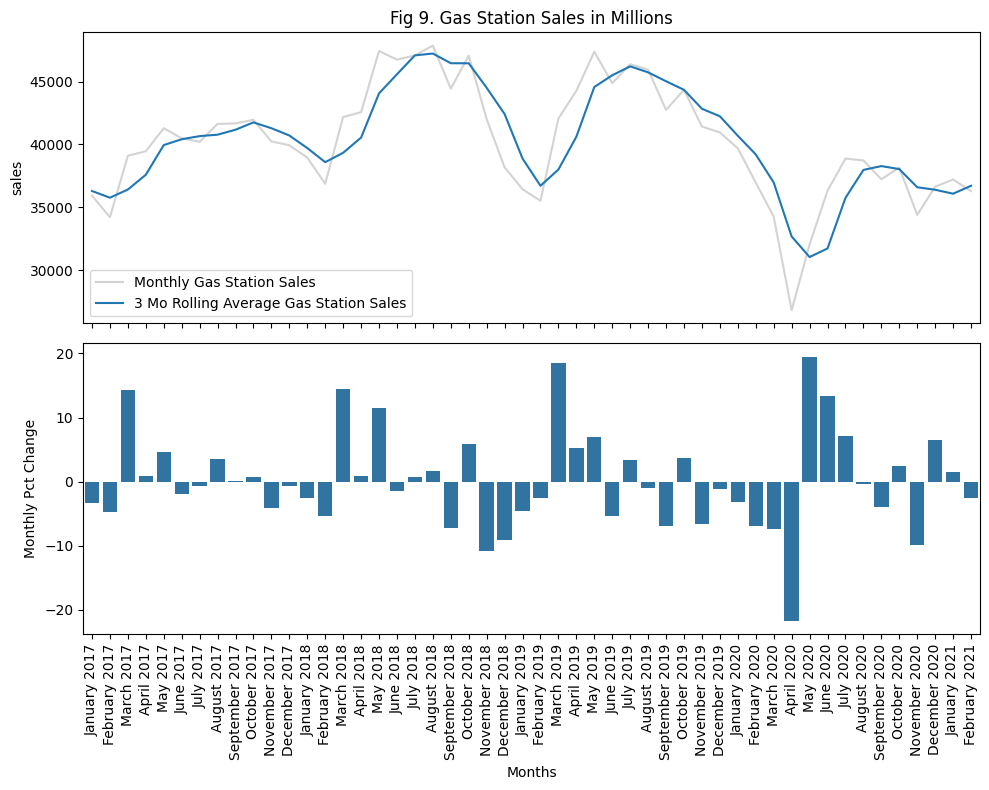

In [109]:
pct_cng = pct_change_df[pct_change_df['month_start'] >= '2017-01-01']

fig, (ax5, ax3) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

ax5 = sns.lineplot(x='month_year', y='sales', data=pct_cng, errorbar=None, estimator='sum', ax=ax5, color='lightgrey')
sns.lineplot(x='month_year', y='rolling_avg_sales', data=pct_cng, estimator=None, errorbar=None, ax=ax5)
ax5.set_title('Fig 9. Gas Station Sales in Millions')
ax5.legend(labels=["Monthly Gas Station Sales", "3 Mo Rolling Average Gas Station Sales"])

sns.barplot(x='month_year', y='pct_change', data=pct_cng, orient='v', errorbar=None, estimator='sum', ax=ax3)

ax3.set_xticklabels(pct_cng['month_year'], rotation=90)
ax3.set_ylabel('Monthly Pct Change')
ax3.set_xlabel('Months')



plt.tight_layout()

plt.show()

In [25]:
cnx = mc.connect(**config)

query = '''
select 
	Business_type,
    month_start,
    month_year,
    sales,
    avg(sales) over(partition by Business_type order by month_start rows between 3 PRECEDING and CURRENT ROW) as rolling_avg_sales
from mrts_data
where naics_code in (44811, 44812)
'''

rolling_df = pd.read_sql(query, cnx)

cnx.close()

C:\Users\sre\AppData\Local\Temp\ipykernel_22172\2011149671.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  rolling_df = pd.read_sql(query, cnx)


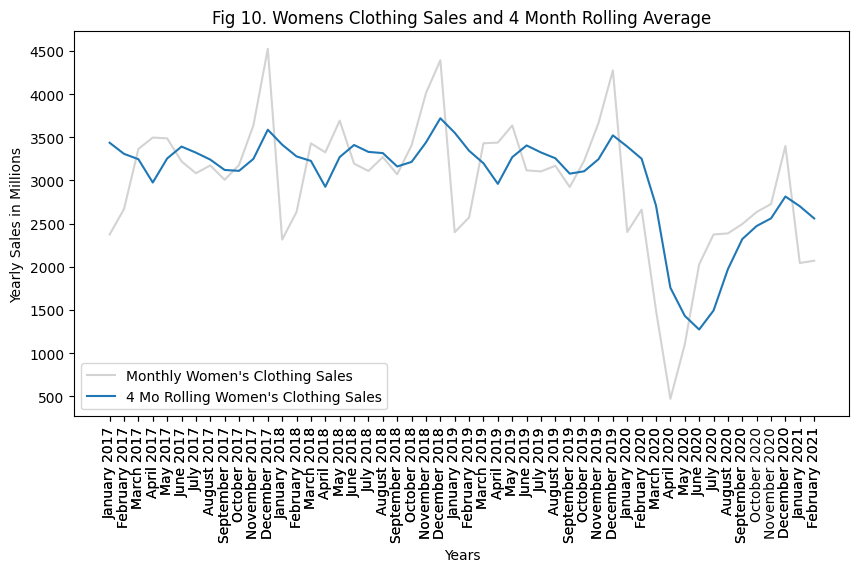

In [103]:
# graphing raw monthly sales in light grey in order to better contrast with the 4 month rolling average.
rolling_df_filtered = rolling_df[rolling_df['month_start'] >= '2017-01-01'].sort_values('month_start')

fig = plt.subplots(figsize=(10, 5))

x1_line = sns.lineplot(x='month_year', y='sales', data=rolling_df_filtered[rolling_df_filtered['Business_type'] == "Women's clothing stores"], errorbar=None, label="Monthly Women's Clothing Sales", color='lightgrey')
sns.lineplot(x='month_year', y='rolling_avg_sales', data=rolling_df_filtered[rolling_df_filtered['Business_type'] == "Women's clothing stores"], estimator=None, errorbar=None, ax=x1_line)

plt.xticks(ticks=rolling_df_filtered['month_year'], rotation=90)
plt.xlabel('Years')
plt.ylabel('Yearly Sales in Millions')
plt.legend(labels=["Monthly Women's Clothing Sales", "4 Mo Rolling Women's Clothing Sales"])
plt.title('Fig 10. Womens Clothing Sales and 4 Month Rolling Average')
plt.show()

[Back to top](#Index)

## Conclusion

According to my analysis, it seems likely that bookstores will continue to wane in popularity.  The only seasonal spike besides a relatively anemic holiday season is the back to school season in August and September.

Women's clothing stores also seem to be in trouble, at least using the currently available data.  They have not yet recovered from the initial shock of the pandemic and the trend, at least for now, it not promising.

On the other hand, sporting goods stores, while taking an initial hit after March 2020, have been thriving.  Even when adjusting for inflation, they have seen a very steady growth over the last 30+ years.  I would speculate that, if the pandemic and Amazon have not yet killed this industry, it will be hard to see it slowing down soon.




[Back to top](#Index
)
## References

**aksrathod07**. “**Python – List Files in a Directory”.** [geeksforgeeks.org](http://geeksforgeeks.org/). **Sanchhaya Education Private Limited. 20 Jun, 2024**. https://www.geeksforgeeks.org/python-list-files-in-a-directory/

**jssuriyakumar**. “**How to Show Values on Seaborn Barplot?”.** [geeksforgeeks.org](http://geeksforgeeks.org/). **Sanchhaya Education Private Limited. 13 Jan, 2022**. https://www.geeksforgeeks.org/how-to-show-values-on-seaborn-barplot/

[David Palmquist](https://github.com/quist00). “**Indexing, Slicing and Subsetting DataFrames in Python”.** [datacarpentry.org](http://datacarpentry.org/). 2024-02-26. https://datacarpentry.org/python-ecology-lesson/03-index-slice-subset.html#indexing-and-slicing-in-python

Stack Overflow

asked by [BenDundee](https://stackoverflow.com/users/963250/bendundee), answered by [U2EF1](https://stackoverflow.com/users/507762/u2ef1), “[**Append column to pandas dataframe](https://stackoverflow.com/questions/20602947/append-column-to-pandas-dataframe)”, Stackoverflow.com. Stack Exchange Inc., Dec 16, 2013.** https://stackoverflow.com/questions/20602947/append-column-to-pandas-dataframe

asked by [Adam_G](https://stackoverflow.com/users/823859/adam-g), answered by [EdChum](https://stackoverflow.com/users/704848/edchum). “[**Convert Pandas DataFrame Column From String to Int Based on Conditional](https://stackoverflow.com/questions/31790287/convert-pandas-dataframe-column-from-string-to-int-based-on-conditional)”, Stackoverflow.com. Stack Exchange Inc., Aug 3, 2015**  https://stackoverflow.com/questions/31790287/convert-pandas-dataframe-column-from-string-to-int-based-on-conditional

asked by [Chubaka](https://stackoverflow.com/users/2736467/chubaka), answered by [MaxU - stand with Ukraine](https://stackoverflow.com/users/5741205/maxu-stand-with-ukraine), “**convert a column in a python pandas from STRING MONTH into INT”, Stackoverflow.com. Stack Exchange Inc., Mar 9, 2017.** https://stackoverflow.com/questions/42684530/convert-a-column-in-a-python-pandas-from-string-month-into-int

asked by [Prashant](https://stackoverflow.com/users/8568679/prashant), answered by [Hadrien](https://stackoverflow.com/users/7411772/hadrien), “[**How to convert multiple excel sheets to csv python](https://stackoverflow.com/questions/48559356/how-to-convert-multiple-excel-sheets-to-csv-python)”, Stackoverflow.com. Stack Exchange Inc., Feb 1, 2018 .** [https://stackoverflow.com/questions/20602947/append-column-to-pandas-dataframe](https://stackoverflow.com/questions/48559356/how-to-convert-multiple-excel-sheets-to-csv-python)v

asked by [user3504322](https://stackoverflow.com/users/3504322/user3504322), answered by [Peybae](https://stackoverflow.com/users/5432304/peybae), “[**Formatting y-axis matplotlib with thousands separator and font size](https://stackoverflow.com/questions/51734218/formatting-y-axis-matplotlib-with-thousands-separator-and-font-size)”, Stackoverflow.com. Stack Exchange Inc., Aug 7, 2018 .** https://stackoverflow.com/questions/51734218/formatting-y-axis-matplotlib-with-thousands-separator-and-font-size

asked by [user_12](https://stackoverflow.com/users/11816060/user-12), answered by [JBirdVegas](https://stackoverflow.com/users/873237/jbirdvegas), “[**How to execute a .sql file using mysql connector and save it in a database in python?](https://stackoverflow.com/questions/59848116/how-to-execute-a-sql-file-using-mysql-connector-and-save-it-in-a-database-in-py)”, Stackoverflow.com. Stack Exchange Inc., Jan 21, 2020 .** https://stackoverflow.com/questions/59848116/how-to-execute-a-sql-file-using-mysql-connector-and-save-it-in-a-database-in-py

asked by [Saeed](https://stackoverflow.com/users/11653374/saeed), answered by [wind](https://stackoverflow.com/users/14318365/wind), “[**How to use `pd.read_sql` using `mysql.connector`](https://stackoverflow.com/questions/64565904/how-to-use-pd-read-sql-using-mysql-connector)”, Stackoverflow.com. Stack Exchange Inc., Oct 28, 2020.** https://stackoverflow.com/questions/64565904/how-to-use-pd-read-sql-using-mysql-connector

US CENSUS

**US Census Bureau**, “**Economic Census: NAICS Codes & Understanding Industry Classification Systems”.** February 12, 2024. https://www.census.gov/programs-surveys/economic-census/year/2022/guidance/understanding-naics.html#par_textimage_1

**US Census Bureau**, “**Business and Industry”. census.gov, US Census Bureau. June 28**, 2024. [https://www.census.gov/econ/currentdata/?programCode=MARTS&startYear=1992&endYear=2024&categories[]=44X72&dataType=SM&geoLevel=US&adjusted=1&notAdjusted=1&errorData=0](https://www.census.gov/econ/currentdata/?programCode=MARTS&startYear=1992&endYear=2024&categories%5B%5D=44X72&dataType=SM&geoLevel=US&adjusted=1&notAdjusted=1&errorData=0)

**US Census Bureau**, “**North American Industry Classification System, Frequently Asked Questions (FAQs)**”. **census.gov, US Census Bureau. 07/07/2024**. https://www.census.gov/programs-surveys/economic-census/year/2022/guidance/understanding-naics.html#par_textimage_1

**US Census Bureau**, “2017_definition_file”. **census.gov, US Census Bureau.** February 12, 2024. https://www.census.gov/naics/2017NAICS/2017_Definition_File.pdf

**US Census Bureau**, “2017_NAICS_manual”. **census.gov, US Census Bureau. 07/07/2024**. https://www.census.gov/naics/reference_files_tools/2017_NAICS_Manual.pdf

**US Census Bureau**, “**Monthly Retail Trade Data**”. **census.gov, US Census Bureau.** *May 17, 2024*. https://www.census.gov/retail/data.html

Bureau of Labor Statistics, “12-month percentage change, Consumer Price Index, selected categories”. bls**.gov,** [Bureau of Labor Statistics](https://www.bls.gov/)**. accessed 7/7/2024**. https://www.bls.gov/charts/consumer-price-index/consumer-price-index-by-category-line-chart.htm

Federal Reserve of St. Louis, “**Consumer Price Index for All Urban Consumers: All Items Less Food and Energy in U.S. City Average”.** [fred.stlouisfed.org](http://fred.stlouisfed.org/). Federal Reserve of St. Louis. Jun 12, 2024. https://fred.stlouisfed.org/series/CPILFESL

Richard C. “**How do I insert multiple rows in a single SQL query?**” [sentry.io/](https://sentry.io/) **FUNCTIONAL SOFTWARE, INC.** August 15, 2023. URL https://sentry.io/answers/how-do-i-insert-multiple-rows-in-a-single-sql-query/.
python-graph-gallery. “**Stacked and Percent Stacked Barplot using Seaborn**” [python-graph-gallery.com](http://python-graph-gallery.com/).  the Python Graph Gallery, 07-07-2024. URL https://python-graph-gallery.com/stacked-and-percent-stacked-barplot/.

[Ignacio L. Bisso](https://learnsql.com/authors/ignacio-l-bisso/). “**What Is a Rolling Average and How Do You Compute It in SQL?**” [learnsql.com](http://learnsql.com/). [**Vertabelo SA**](https://www.vertabelo.com/), 29th Oct 2021. https://learnsql.com/blog/rolling-average-in-sql/.

